<a href="https://colab.research.google.com/github/Ratexzeus/Ratex/blob/main/CV1_%2B%2B_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os

In [ ]:
# import zipfile

# zip_file_path = '/content/drive/MyDrive/archive (2).zip'  # Replace 'your_zip_file.zip' with the actual file name

# # Specify the target directory where you want to extract the contents
# extracted_dir = '/content/drive/MyDrive/NewStuff/'  # Replace 'extracted/' with your desired directory

# # Create the target directory if it doesn't exist
# import os
# os.makedirs(extracted_dir, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_dir)

# print(f'Extracted contents to {extracted_dir}')


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/NewStuff/Testing_set.csv')
train_df = pd.read_csv('/content/drive/MyDrive/NewStuff/Training_set.csv')

In [ ]:
train_names = ['/content/drive/MyDrive/NewStuff/train/' + fname for fname in train_df['filename']]

In [ ]:
train_names[:10]

['/content/drive/MyDrive/NewStuff/train/Image_1.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_2.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_3.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_4.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_5.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_6.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_7.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_8.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_9.jpg',
 '/content/drive/MyDrive/NewStuff/train/Image_10.jpg']

In [ ]:
labels = train_df['label'].to_numpy()
unique_breeds = np.unique(labels)
len(unique_breeds)

# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, Fal

In [ ]:
from IPython.display import Image# Convert an image to numpy
from matplotlib.pyplot import imread
image = imread(train_names[42])
image.shape

(224, 224, 3)

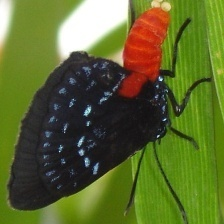

In [ ]:
Image(train_names[6498])

In [ ]:
X = train_names
y = boolean_labels

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2 )

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the assosciated label,
  processes the image and returns a tuple of (image, label).
  '''
  image = process_image(image_path)
  return image, label

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input(no labels)
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

    # If the data is a valid dataset, we don't need a to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),     #filepaths
                                                 tf.constant(y)))    #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shufflin pathnames and label  s before mapping image proccesor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    # turn training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch




In [ ]:
 # Create training and validation data batches
train_data = create_data_batches(train_images, train_labels)
val_data = create_data_batches(test_images, test_labels, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
import matplotlib.pyplot as plt

#create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display am image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

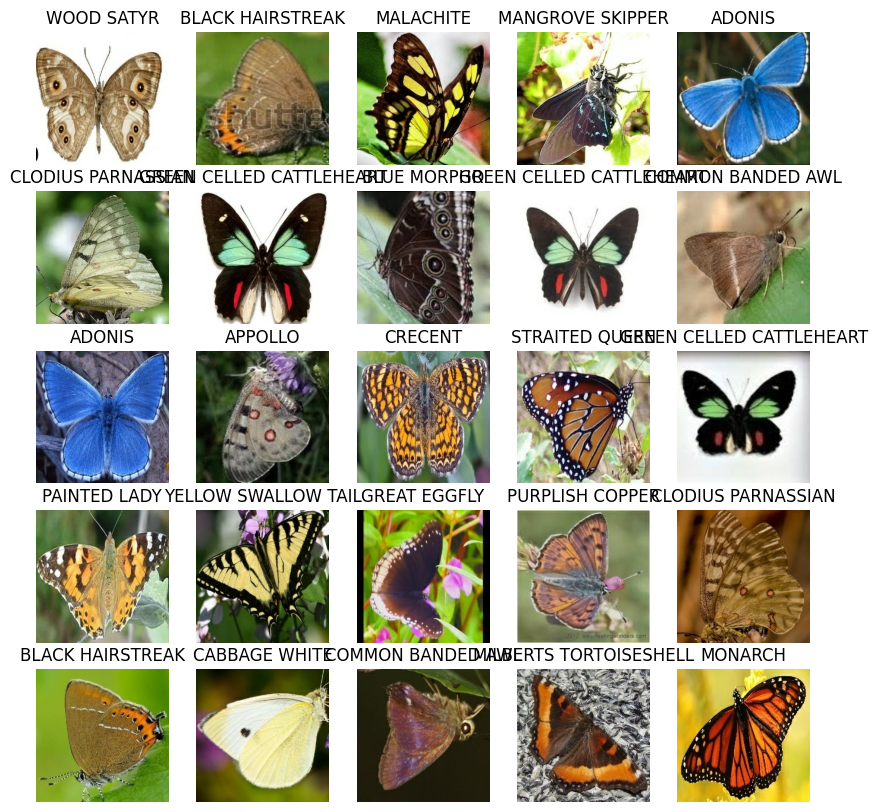

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [ None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building model with:', MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),# Layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation='softmax') # Layer 2 (output layer)
                               ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Load TensorBoard Nnotebook extension
%load_ext tensorboard
import datetime

# Create a function tu build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join('drive/MyDrive/NewStuff/logs',
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S%'))
  return tf.keras.callbacks.TensorBoard(logdir)


In [ ]:
# Create early stoping callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

In [ ]:
 # Build a function to train and return a trained model
def train_model():
  '''
  Trains a given model and returns the trained version
  '''
  # Create a model
  model = create_model()

  # Create new Tensorboard session everytime
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    validation_freq=1,
    callbacks=[tensorboard, early_stopping],
    verbose=1
)
  # Return the fitted model
  return model

In [ ]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/20
163/163 [==============================] - 1245s 8s/step - loss: 1.6813 - accuracy: 0.6251 - val_loss: 0.7641 - val_accuracy: 0.8062
Epoch 2/20
163/163 [==============================] - 13s 78ms/step - loss: 0.4787 - accuracy: 0.8900 - val_loss: 0.5795 - val_accuracy: 0.8477
Epoch 3/20
163/163 [==============================] - 12s 74ms/step - loss: 0.2985 - accuracy: 0.9317 - val_loss: 0.5058 - val_accuracy: 0.8615
Epoch 4/20
163/163 [==============================] - 11s 70ms/step - loss: 0.2019 - accuracy: 0.9604 - val_loss: 0.4612 - val_accuracy: 0.8638
Epoch 5/20
163/163 [==============================] - 12s 75ms/step - loss: 0.1482 - accuracy: 0.9736 - val_loss: 0.4668 - val_accuracy: 0.8700
Epoch 6/20
163/163 [==============================] - 12s 74ms/step - loss: 0.1134 - accuracy: 0.9804 - val_loss: 0.4555 - val_accuracy: 0.8654
Epoch 7/20
163/163 [=======================

In [ ]:
# Make predictions on the validation data (not ussed to train on)
predictions = model.predict(val_data,verbose=1)
predictions

41/41 [==============================] - 3s 53ms/step


array([[4.0777768e-09, 9.7130695e-08, 1.0065253e-09, ..., 1.6407789e-08,
        6.3867759e-08, 1.4567937e-07],
       [1.3652005e-06, 1.2490497e-05, 1.4508326e-05, ..., 1.1715013e-06,
        3.4427317e-04, 1.2499928e-06],
       [5.7790861e-09, 5.6687923e-06, 4.2084402e-08, ..., 2.2437224e-08,
        1.4138921e-06, 1.6560145e-08],
       ...,
       [1.0269464e-07, 2.0542922e-08, 1.9414745e-07, ..., 6.5900053e-08,
        3.6906133e-06, 1.8780295e-08],
       [3.5509816e-05, 7.3582117e-07, 5.6989335e-05, ..., 1.3353354e-05,
        9.3051522e-06, 3.9222559e-06],
       [1.5648973e-06, 1.9560059e-06, 2.8141862e-08, ..., 4.9837645e-06,
        1.0144327e-06, 2.1999433e-06]], dtype=float32)

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'EASTERN DAPPLE WHITE'

In [ ]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 75), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 75), dtype=tf.bool, name=None)))

In [ ]:
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.9294118 , 0.9294118 , 0.9294118 ],
         [0.9333334 , 0.9333334 , 0.9333334 ],
         [0.9333334 , 0.9333334 , 0.94117653],
         ...,
         [0.8862746 , 0.89019614, 0.9058824 ],
         [0.87843144, 0.882353  , 0.8980393 ],
         [0.8745099 , 0.87843144, 0.8941177 ]],
 
        [[0.9333334 , 0.9333334 , 0.9333334 ],
         [0.9333334 , 0.9333334 , 0.9333334 ],
         [0.93725497, 0.93725497, 0.9450981 ],
         ...,
         [0.89019614, 0.8941177 , 0.909804  ],
         [0.882353  , 0.8862746 , 0.90196085],
         [0.87843144, 0.882353  , 0.8980393 ]],
 
        [[0.94117653, 0.94117653, 0.94117653],
         [0.94117653, 0.94117653, 0.94117653],
         [0.94117653, 0.94117653, 0.9490197 ],
         ...,
         [0.8941177 , 0.8980393 , 0.91372555],
         [0.8862746 , 0.89019614, 0.9058824 ],
         [0.882353  , 0.8862746 , 0.90196085]],
 
        ...,
 
        [[0.9215687 , 0.9215687 , 0.9215687 ],
         [0.9215687 , 0.9215687 , 0.92156

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

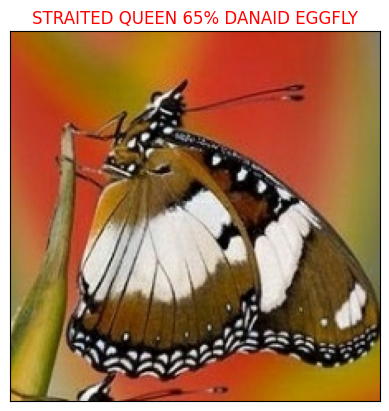

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=114)